In [3]:
import os
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import OrderedDict
import itertools as it
from functools import reduce 
import time

# Helper Functions

In [3]:
def k_fold_cross_validation(data, k):
    """
    params:
        data: This should be a pandas data frame
        k: This is an int indicating the folds of the data to be performed
           If k is 0, perform LOO cross-validation: TODO
           If k is 1, the data is both test and train
    output:
        train: This is a pandas data frame
        test: This is a pandas data frame
        cross: This is which kth fold that we have just yielded
    """
    if k == 1:
        yield(data, data, k)
        return()
    if k == 0: # TODO: double check
        for i, value in enumerate(data):
            train = data[:i].append(data[(i+1):])
            test = data[i:(i+1)]
            yield(train, test, i)
    size = len(data)
    for cross in range(k):
        start = int(cross*size/k)
        stop = int((cross+1)*size/k)
        train = data[:start].append(data[stop:])
        test = data[start:stop]
        yield(train,test,cross)

In [4]:
def run_algorithm(train, test, algorithm):
    """
    params:
        train: a pandas data frame of the data
        test: a pandas data frame of the data
        algorithm: a pointer to a function that takes in data and outputs predictions
        #   params:
        #       data: a pandas dataframe
        #       info: information from training. If not present, train the model
        #   outputs:
        #       values: if training, it will output the parameters learned during training
        #               if testing, it will output the confusion_matrix
    outputs:
        confusion_matrix: The confusion matrix of the boolean classification
        duration: The amount of time that this took to run
        training_info: The necessary information to just run the algorithm without training again
    """
    start = time.time()
    training_info = algorithm(train)
    confusion_matrix = algorithm(test, training_info)
    duration = time.time() - start
    return(confusion_matrix, duration, training_info)

In [5]:
def accuracy(confusion_matrix):
    """
    params:
        confusion_matrix: a dictionary where entries are of the form {(T/F,T/F):freq}
                          freq is the occurence of that prediction outcome
    ouputs:
        The output is a float between 0 and 1 indicating the overall accuracy of the \
        model given the binary confusion matrix.
    """
    correct = confusion_matrix[(True, True)]+confusion_matrix[(False, False)]
    return(correct/sum(list(confusion_matrix.values())))

In [6]:
def add_term(dicto, word, sarcasm):
        if not word in dicto:
            dicto[word] = [0,0]
            dicto[word][sarcasm] = 1  #if this is the first time we see the word, make its count the step
        else:
            dicto[word][sarcasm] += 1 #increment the count with another sighting

# Model Functions

In [7]:
def prior(data,info=None):
    values = None
    if info is None:
        prior=sum(data['is_sarcastic'])/len(data)
        values = prior
    else:
        answer = 0
        # If 1 is more common than 0, guess 1.
        if info > 0.5:
            answer = 1
        confusion_matrix = {x:0 for x in it.product([0,1],repeat=2)}
        for x in data['is_sarcastic']:
            confusion_matrix[(answer,x)] += 1
        values = confusion_matrix
    return(values)

In [8]:
def NB(data,info=None):
    values = None
    counts = {}
    if info is None:
        for entry, sarc in zip(data['headline'],data['is_sarcastic']):
            for word in entry.split(" "):
                add_term(counts, word, sarc)
        v=list(it.chain(*list(counts.values())))
        num_serious_words=sum(v[0::2])
        num_sarcastic_words=sum(v[1::2])
        for word in counts:
            counts[word][0] /= num_serious_words
            counts[word][1] /= num_sarcastic_words
        values = counts
    else:
        confusion_matrix = {x:0 for x in it.product([0,1],repeat=2)}
        for entry, sarc in zip(data['headline'],data['is_sarcastic']):
            # For every headline, multiply the frequency of each word for each class
            # If a word in the test set is not found in the training set, ignore it
            r = list(it.chain(*[info.get(word, [1,1]) for word in entry.split(" ")]))
            p_serious = reduce((lambda x, y: x * y), r[0::2]) 
            p_sarcasm = reduce((lambda x, y: x * y), r[1::2]) 
            result=(p_serious < p_sarcasm, bool(sarc))
            confusion_matrix[result] += 1
        values = confusion_matrix
    return(values)

In [9]:
def NB_rank(data,info=None):
    values = None
    counts = {}
    if info is None:
        for entry, sarc in zip(data['headline'],data['is_sarcastic']):
            for word in entry.split(" "):
                add_term(counts, word, sarc)
        # Get the ranks of each word in reference to serious
        ordered_counts_ser=OrderedDict(sorted(counts.items(), reverse=True, key=lambda x: x[1][0]))
        for i,count in enumerate(ordered_counts_ser):
            ordered_counts_ser[count][0]=i
        # Get the ranks of each word in reference to sarcasm
        ordered_counts_sarc=OrderedDict(sorted(ordered_counts_ser.items(), reverse=True, key=lambda x: x[1][1]))
        for i,count in enumerate(ordered_counts_sarc):
            ordered_counts_sarc[count][1]=i
        values = ordered_counts_sarc
    else:
        confusion_matrix = {x:0 for x in it.product([0,1],repeat=2)}
        for entry, sarc in zip(data['headline'],data['is_sarcastic']):
            # If a word in the test set is not found in the training set, ignore it
            r=list(it.chain(*[info.get(word,[0,0]) for word in entry.split(" ")]))
            # For every headline, add up the rankings of each word for each class
            psar = sum(r[1::2])
            pser = sum(r[0::2])
            result=(pser > psar,bool(sarc))
            confusion_matrix[result] += 1
        values = confusion_matrix
    return(values)

# Let's Test the Classifiers!

### Let's Get the Data First

The next couple parts are borrowed from work by Tanumoy Nandy at https://www.kaggle.com/tanumoynandy/sarcasm-detection-lstm.

In [4]:
data=pd.read_json('../data/Sarcasm_Headlines_Dataset.json', lines=True)
data[['headline','is_sarcastic']].head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


Text(0.5, 1.0, 'Sarcasm vs Non-sarcasm')

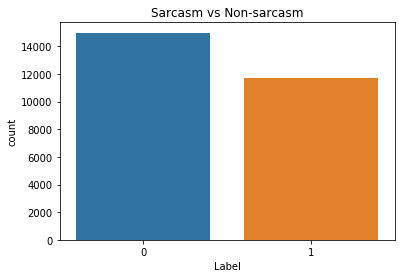

In [9]:
# Get prior proportions
sns.countplot(data.is_sarcastic)
plt.xlabel('Label')
plt.title('Sarcasm vs Non-sarcasm')

In [12]:
# remove upper case, weird white space and punctuation
data['headline'] = data['headline'].apply(lambda x: x.lower())
data['headline'] = data['headline'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
data[['headline','is_sarcastic']].head()

,headline,is_sarcastic
0,former versace store clerk sues over secret bl...,0
1,the roseanne revival catches up to our thorny ...,0
2,mom starting to fear sons web series closest t...,1
3,boehner just wants wife to listen not come up ...,1
4,jk rowling wishes snape happy birthday in the ...,0


## Human Accuracy

Here, I shall try to classify headlines myself. I shall take a group of 30 headlines and assign them sarcastic or not sarcastic. This will act as a baseline for any algorithms we test. If any of the the classification schemes perform better than I do, we will consider it as performing at superhuman levels.

In [16]:
for v in data['headline'][600:630]:
    print(v + '\n')

hillary clinton loses lead over bernie sanders in new iowa poll

several women accuse progressive media executive don hazen of sexual harassment

success and still enjoying your 'happy place'

last 12 years a real wake-up call for area man

pollsters admit they underestimated voters' adrenal glands

lin-manuel miranda freestyles about life's most annoying minor inconveniences on 'ellen'

john lewis won't attend civil rights museum opening because trump is going

is trouble brewing for the 2015 npt review conference?

area man going to go ahead and consider that a date

4 senators mauled during congressional tiger show

huffpost hill - secret service agents really glad dark sunglasses hide bloodshot eyes

kite flyer in the zone

bacon just one of sprint's new downloadable ring scents

i photograph to remember

u.s. bobsled team pays tribute to late gold medalist steven holcomb

among santa fe's many virtues? history, art, culture, hospitality and killer vintage clothing

power plan foes

In [12]:
guess = [0,1,0,1,1,0,0,0,1,1,1,0,1,1,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,1]

In [13]:
ans = data['is_sarcastic'][600:630]

In [14]:
(30-sum(abs(ans-guess)))/30

0.7333333333333333

### Let's Now Run the Algorithms

In [13]:
# prior
acc = 0
k=10
for train, test, cross in k_fold_cross_validation(data, k): 
    confusion_matrix, duration = run_algorithm(train, test, prior)
    acc += accuracy(confusion_matrix)
print(acc/k)

0.5610465998370626


In [14]:
# NB
acc = 0
k=10
for train, test, cross in k_fold_cross_validation(data, k): 
    confusion_matrix, duration = run_algorithm(train, test, NB)
    acc += accuracy(confusion_matrix)
print(acc/k)

0.7730727175082064


In [15]:
# NB_rank
acc = 0
k=5
for train, test, cross in k_fold_cross_validation(data, k): 
    confusion_matrix, duration = run_algorithm(train, test, NB_rank)
    acc += accuracy(confusion_matrix)
print(acc/k)

0.7483996107897406


It seems that worst case scenario, we will get 0.56 accuracy through guessing one value all the time. However, if we use NB, we can achieve an accuracy of around 0.77. This is a C+.

If we want to generate headlines, we will want a classifier that does even better. I will arbitrarily set the threshold to 95%. Why? Because when we give NB the opportunity to memorize, it can achieve 96% accuracy.

Notice that we are only removing non-alphanumerics and uppercase, but we are not removing things like conjugation for tense or number. We are also not removing stop words.

# NLTK

In [48]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jeffr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jeffr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [49]:
from nltk.corpus import stopwords
stop=list(stopwords.words('english'))[:]

In [50]:
sentence="First shalt thou take out the Holy Pin. Then, shalt thou count to three, no more, no less.".lower()
[w for w in word_tokenize(sentence) if not w in stop]

['first',
 'shalt',
 'thou',
 'take',
 'holy',
 'pin',
 '.',
 ',',
 'shalt',
 'thou',
 'count',
 'three',
 ',',
 ',',
 'less',
 '.']

### Classifiers with nltk

Let's see what happens when we modify the pipeline so that we exclude the stopwords that the nltk library provides for us.

In [55]:
def NB_nltk(data,info=None):
    values = None
    counts = {}
    if info is None:
        for entry, sarc in zip(data['headline'],data['is_sarcastic']):
            for word in entry.split(" "):
                if not word in stop:
                    add_term(counts, word, sarc)
        v=list(it.chain(*list(counts.values())))
        num_serious_words=sum(v[0::2])
        num_sarcastic_words=sum(v[1::2])
        for word in counts:
            counts[word][0] /= num_serious_words
            counts[word][1] /= num_sarcastic_words
        values = counts
    else:
        confusion_matrix = {x:0 for x in it.product([0,1],repeat=2)}
        for entry, sarc in zip(data['headline'],data['is_sarcastic']):
            # For every headline, multiply the frequency of each word for each class
            # If a word in the test set is not found in the training set, ignore it
            r = list(it.chain(*[info.get(word, [1,1]) for word in entry.split(" ")]))
            p_serious = reduce((lambda x, y: x * y), r[0::2]) 
            p_sarcasm = reduce((lambda x, y: x * y), r[1::2]) 
            result=(p_serious < p_sarcasm, bool(sarc))
            confusion_matrix[result] += 1
        values = confusion_matrix
    return(values)

In [56]:
def NB_rank_nltk(data,info=None):
    values = None
    counts = {}
    if info is None:
        for entry, sarc in zip(data['headline'],data['is_sarcastic']):
            for word in entry.split(" "):
                if not word in stop:
                    add_term(counts, word, sarc)
        # Get the ranks of each word in reference to serious
        ordered_counts_ser=OrderedDict(sorted(counts.items(), reverse=True, key=lambda x: x[1][0]))
        for i,count in enumerate(ordered_counts_ser):
            ordered_counts_ser[count][0]=i
        # Get the ranks of each word in reference to sarcasm
        ordered_counts_sarc=OrderedDict(sorted(ordered_counts_ser.items(), reverse=True, key=lambda x: x[1][1]))
        for i,count in enumerate(ordered_counts_sarc):
            ordered_counts_sarc[count][1]=i
        values = ordered_counts_sarc
    else:
        confusion_matrix = {x:0 for x in it.product([0,1],repeat=2)}
        for entry, sarc in zip(data['headline'],data['is_sarcastic']):
            # If a word in the test set is not found in the training set, ignore it
            r=list(it.chain(*[info.get(word,[0,0]) for word in entry.split(" ")]))
            # For every headline, add up the rankings of each word for each class
            psar = sum(r[1::2])
            pser = sum(r[0::2])
            result=(pser > psar,bool(sarc))
            confusion_matrix[result] += 1
        values = confusion_matrix
    return(values)

In [57]:
# NB
acc = 0
k=10
for train, test, cross in k_fold_cross_validation(data, k): # never before seen words
    confusion_matrix, duration = run_algorithm(train, test, NB_nltk)
    acc += accuracy(confusion_matrix)
print(acc/k)

0.74678959892422


In [58]:
# NB_rank
acc = 0
k=10
for train, test, cross in k_fold_cross_validation(data, k): # never before seen words
    confusion_matrix, duration = run_algorithm(train, test, NB_rank_nltk)
    acc += accuracy(confusion_matrix)
print(acc/k)

0.7488487107326999


It appears that removing the stopwords reduces accuracy, but not by much. This is an interesting finding. Let's see if we can get better accuracy using a neural network!

# Neural Network

What we shall try to accomplish here is to run the same NLP analysis using a neural network architecture. We shall use keras.

The following example is pulled directly from https://towardsdatascience.com/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e. This is used as a learning opportunity only and is not part of our project.

In [2]:
import keras

Using TensorFlow backend.


In [3]:
from keras.datasets import imdb

In [4]:
vocabulary_size = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocabulary_size)
print('Loaded dataset with {} training samples, {} test samples'.format(len(X_train), len(X_test)))

17465344/17464789 [==============================] - 3s 0us/step
Loaded dataset with 25000 training samples, 25000 test samples


In [5]:
print('---review---')
print(X_train[6])
print('---label---')
print(y_train[6])

---review---
[1, 2, 365, 1234, 5, 1156, 354, 11, 14, 2, 2, 7, 1016, 2, 2, 356, 44, 4, 1349, 500, 746, 5, 200, 4, 4132, 11, 2, 2, 1117, 1831, 2, 5, 4831, 26, 6, 2, 4183, 17, 369, 37, 215, 1345, 143, 2, 5, 1838, 8, 1974, 15, 36, 119, 257, 85, 52, 486, 9, 6, 2, 2, 63, 271, 6, 196, 96, 949, 4121, 4, 2, 7, 4, 2212, 2436, 819, 63, 47, 77, 2, 180, 6, 227, 11, 94, 2494, 2, 13, 423, 4, 168, 7, 4, 22, 5, 89, 665, 71, 270, 56, 5, 13, 197, 12, 161, 2, 99, 76, 23, 2, 7, 419, 665, 40, 91, 85, 108, 7, 4, 2084, 5, 4773, 81, 55, 52, 1901]
---label---
1


In [6]:
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}
print('---review with words---')
print([id2word.get(i, ' ') for i in X_train[6]])
print('---label---')
print(y_train[6])

1646592/1641221 [==============================] - 0s 0us/step
---review with words---
['the', 'and', 'full', 'involving', 'to', 'impressive', 'boring', 'this', 'as', 'and', 'and', 'br', 'villain', 'and', 'and', 'need', 'has', 'of', 'costumes', 'b', 'message', 'to', 'may', 'of', 'props', 'this', 'and', 'and', 'concept', 'issue', 'and', 'to', "god's", 'he', 'is', 'and', 'unfolds', 'movie', 'women', 'like', "isn't", 'surely', "i'm", 'and', 'to', 'toward', 'in', "here's", 'for', 'from', 'did', 'having', 'because', 'very', 'quality', 'it', 'is', 'and', 'and', 'really', 'book', 'is', 'both', 'too', 'worked', 'carl', 'of', 'and', 'br', 'of', 'reviewer', 'closer', 'figure', 'really', 'there', 'will', 'and', 'things', 'is', 'far', 'this', 'make', 'mistakes', 'and', 'was', "couldn't", 'of', 'few', 'br', 'of', 'you', 'to', "don't", 'female', 'than', 'place', 'she', 'to', 'was', 'between', 'that', 'nothing', 'and', 'movies', 'get', 'are', 'and', 'br', 'yes', 'female', 'just', 'its', 'because', 'm

In [7]:
print('Maximum review length: {}'.format(
len(max((X_train + X_test), key=len))))

Maximum review length: 2697


In [8]:
print('Minimum review length: {}'.format(
len(min((X_test + X_test), key=len))))

Minimum review length: 14


In [9]:
from keras.preprocessing import sequence
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [10]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
embedding_size=32
model=Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

In [12]:
batch_size = 64
num_epochs = 3
X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]
model.fit(X_train2, y_train2, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=num_epochs)

Instructions for updating:
Use tf.cast instead.
Train on 24936 samples, validate on 64 samples
Epoch 1/3
24936/24936 [==============================] - 293s 12ms/step - loss: 0.4808 - acc: 0.7592 - val_loss: 0.2669 - val_acc: 0.9375
Epoch 2/3
24936/24936 [==============================] - 284s 11ms/step - loss: 0.3200 - acc: 0.8662 - val_loss: 0.2150 - val_acc: 0.9531
Epoch 3/3
24936/24936 [==============================] - 285s 11ms/step - loss: 0.2753 - acc: 0.8900 - val_loss: 0.2866 - val_acc: 0.8906


In [39]:
scores = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.86732
